<a href="https://colab.research.google.com/github/DADesai/MSBA/blob/main/MSBA_Time/code/Crypto_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

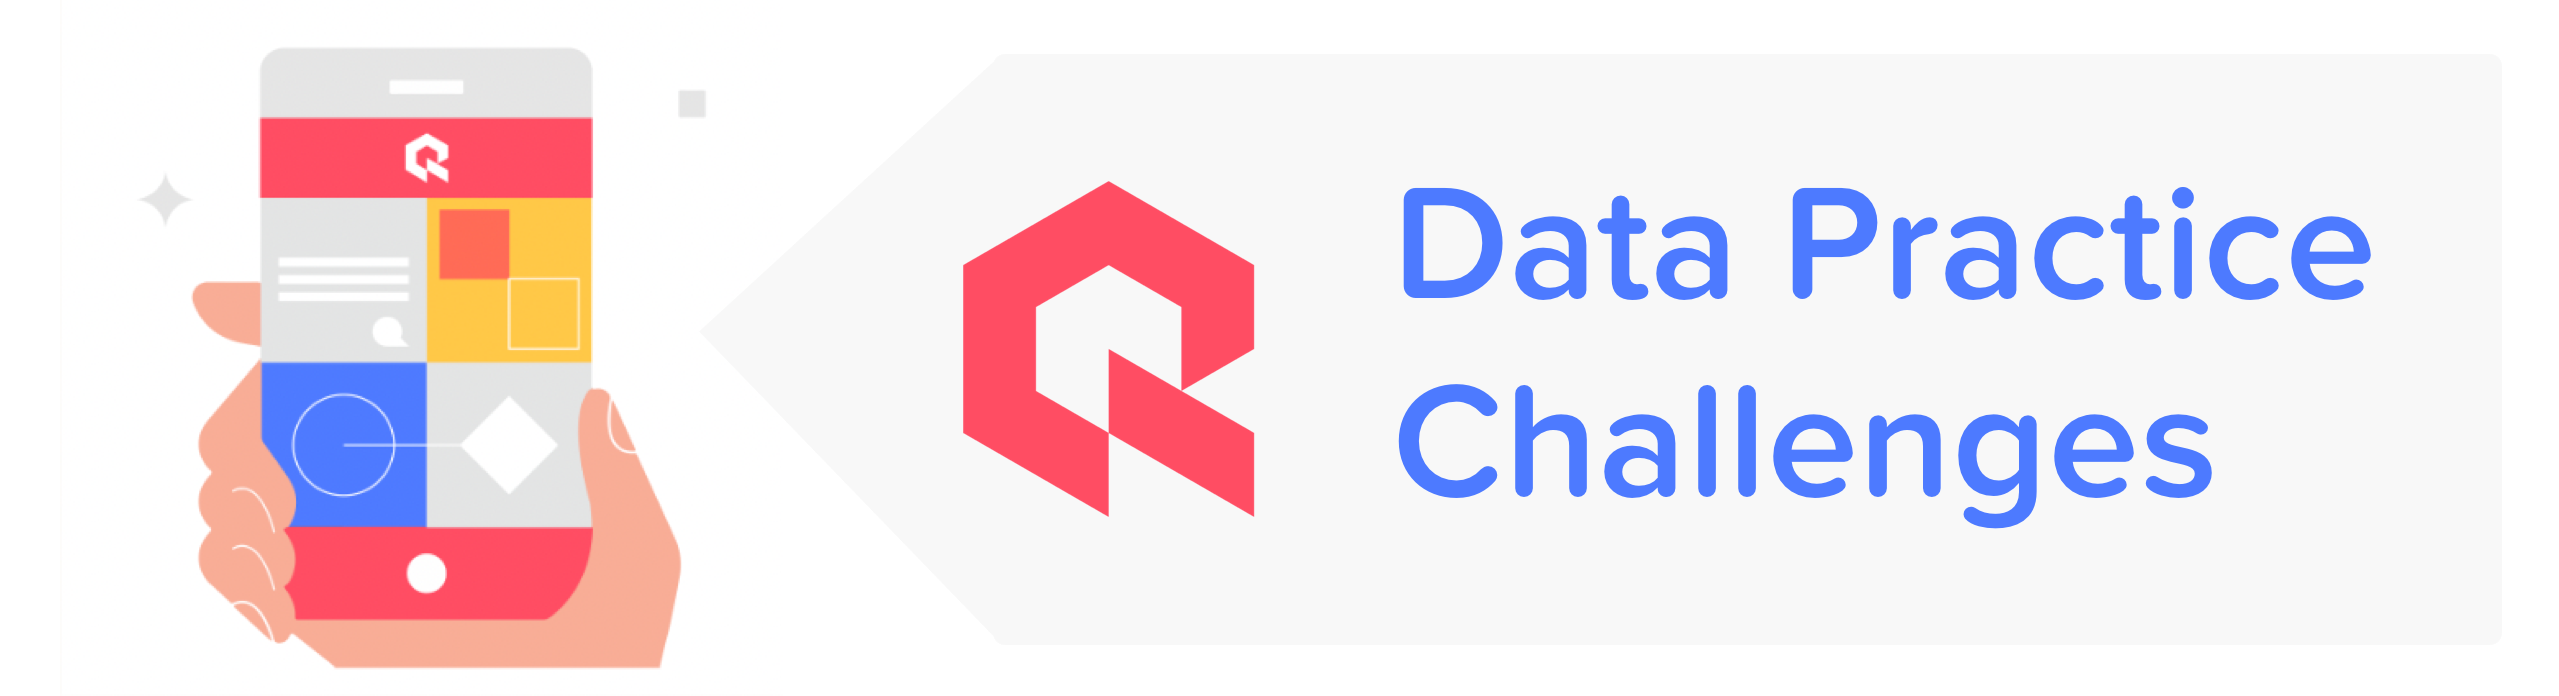

# **Mini Case Study: Leveraging ARIMA for Cryptocurrency Price Forecasting**

## Scenario

As a newly hired data scientist at Data and Divination, you are immediately tasked with a high-stakes project from a crypto trading company. The client, eager to leverage advanced analytics for strategic trading decisions, has provided you with a comprehensive dataset of historical cryptocurrency prices. Your mission is to develop a robust predictive model that can accurately forecast future price trends, providing the company with a competitive edge in the volatile crypto market.

Embracing the challenge, you begin by meticulously preprocessing the data, ensuring it is primed for a sophisticated time-series analysis. Diving deep into the historical trends, you visualize the data to uncover underlying patterns and correlations. Through iterative experimentation with various ARIMA models, you fine-tune the parameters to build an optimal predictive model. Your final task is to generate a reliable forecast for the next ten days, analyzing the confidence intervals to ensure the predictions are robust and actionable. Your work promises to transform the client's trading strategy, illustrating the power of data-driven decision-making in the dynamic world of cryptocurrency trading.

 Here is a [zipped dataset](https://github.com/DADesai/MSBA/blob/main/MSBA_Time/Data/crypto-markets.csv.zip) assigned to you.

## Technical Challenges

* **1. Data Preprocessing**: Preprocess the data to make it ready for the time-series analysis.

* **2: Model Building**: Visualize the data using ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots to identify potential ARIMA(p,d,q) parameters.
Experiment with different combinations of ARIMA parameters and compare their AIC scores. Pick the right parameters and build the best Arima Model.

* **3: Forecasting**: Forecast the next 10 days of cryptocurrency prices using the best ARIMA model. Analyze the forecast's confidence intervals.

You are welcome to use ChatGPT or other AI tools to solve the challenges.

## Discussion Questions

Discuss with your team members:

1. How does the stationarity of time-series data impact the effectiveness of ARIMA models in predicting future cryptocurrency prices, and what preprocessing techniques can be employed to achieve stationarity if the original data is non-stationary?


2. When experimenting with different ARIMA(p,d,q) parameters, how can we balance the trade-off between model complexity and predictive accuracy, and why is it essential to consider both the AIC score and the interpretability of the model?


3. In the context of forecasting cryptocurrency prices, how can the analysis of forecast confidence intervals influence trading decisions, and what strategies can be implemented to mitigate risks associated with prediction uncertainties?

Below is a possible solution of the technical challenges.

## Setup

To get started, let's unzip, load the dataset and understand the data a little bit.

Connect to a hosted runtime, then upload the data file to the root file for this Colab notebook using the panel on the left. Then run the code below.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt

# Load the dataset
df = pd.read_csv('crypto-markets.csv', nrows=100)

# Display the first few rows of the dataframe
df.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0,1488566728,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0,1603768865,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0,1542813125,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0,1298954594,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0,1168517495,0.3881,33.32


## Solution for Challenge 1: Data Preprocessing

We need to ensure that the data is in a suitable format
for time series forecasting. This typically involves:

Checking for missing values and handling them if necessary.
Converting the date column to a datetime data type and setting it as the index of the DataFrame.
Selecting a single cryptocurrency to forecast.
Choosing the price type (open, high, low, close) to use for forecasting.









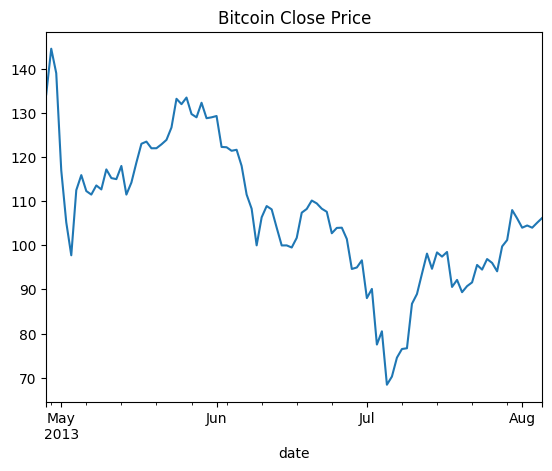

Missing values in BTC close price: 0


In [ ]:


# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Sort the DataFrame by the index
df.sort_index(inplace=True)

# Selecting Bitcoin for forecasting
btc_df = df[df['symbol'] == 'BTC']

# Using 'close' price for forecasting
btc_close = btc_df['close']

# Check for missing values
missing_values = btc_close.isnull().sum()

# Display the preprocessed close prices and missing values
btc_close.plot(title='Bitcoin Close Price')
plt.show()
print(f'Missing values in BTC close price: {missing_values}')

## Solution for Challenge 2: ARIMA Model Building

Now that the data is ready, we can proceed to build an ARIMA model. The ARIMA model requires three parameters (p, d, q):

p: The number of lag observations included in the model (lag order).

d: The number of times that the raw observations are differenced (degree of differencing).

q: The size of the moving average window (order of moving average).

We will start by determining the order of differencing (d) by plotting the autocorrelation function (ACF) and partial autocorrelation function (PACF) to identify the appropriate parameters.

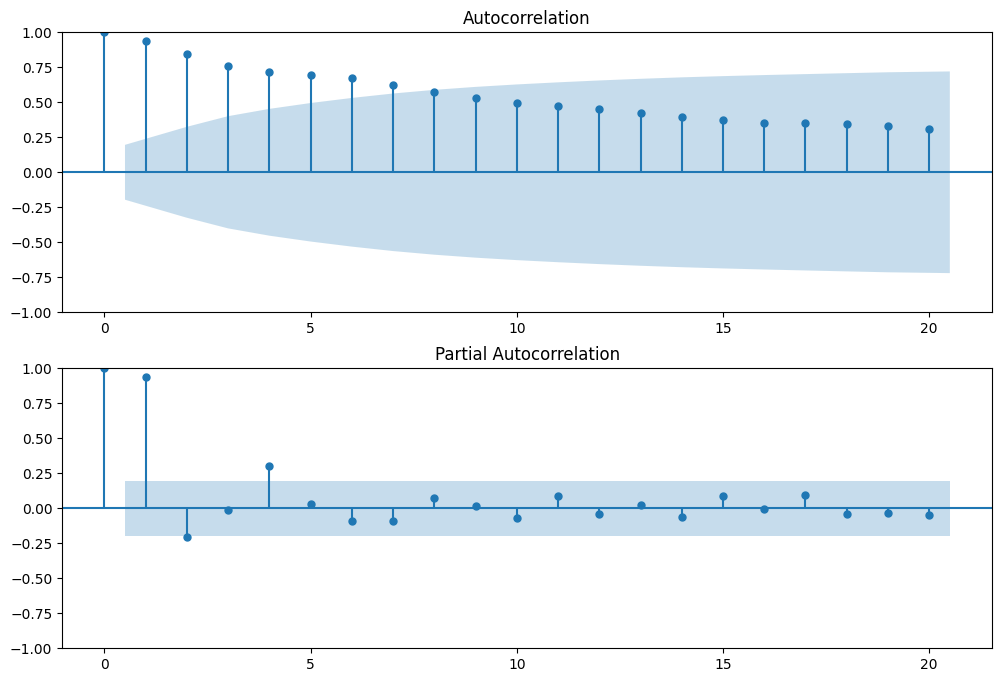

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(btc_close, lags=20, ax=ax1)

# Plot the PACF on ax2
plot_pacf(btc_close, lags=20, ax=ax2)

# Show plot
plt.show()

These plots can help us determine the ARIMA model parameters. Here's how we can interpret them:

The ACF plot shows the correlation of the series with its lags. In a stationary series, the ACF will drop to zero relatively quickly, while the PACF will drop to zero after the lag equal to the order of the AR term.

The PACF plot shows the partial correlation of a series with its own lagged values, controlling for the values of the time series at all shorter lags.

Based on the ACF and PACF plots, we can make initial guesses for the ARIMA parameters.

However, it's often best to use a systematic approach such as the Akaike Information Criterion (AIC) to find the most suitable parameters.

In [ ]:
import warnings
import itertools
from statsmodels.tsa.arima.model import ARIMA

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")

# Ensure the time series has a daily frequency
btc_close = btc_close.asfreq('D')

# Handle missing values by interpolation (optional)
btc_close = btc_close.interpolate()

# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# We are not using seasonal effects in this model, but we define seasonal parameter combinations anyway
seasonal_pdq = [(x[0], x[1], x[2], 0) for x in pdq]

# Search for the optimal set of parameters that yields the best performance for the model
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Fit the ARIMA model with the current set of parameters
            mod = ARIMA(btc_close, order=param)
            results = mod.fit()

            # Compare this model's AIC to the best (lowest) AIC we've seen so far
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
        except Exception as e:
            # Print the error message for debugging
            print(f"An error occurred for parameters {param} and {param_seasonal}: {e}")
            continue

# Output the best parameters and their corresponding AIC value
print(f'Best ARIMA{best_pdq} AIC={best_aic}')


Best ARIMA(2, 1, 2) AIC=600.3303685912418


## Solution for Challenge 3: Forecasting

The ARIMA(2, 1, 2) model has been fitted to the Bitcoin close price data. Now let's perform a forecast.

Below is the model summary and the forecast plot.

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  100
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -295.165
Date:                Thu, 25 Jul 2024   AIC                            600.330
Time:                        02:20:05   BIC                            613.306
Sample:                    04-28-2013   HQIC                           605.580
                         - 08-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3156      0.206     -1.533      0.125      -0.719       0.088
ar.L2         -0.5873      0.194     -3.022      0.003      -0.968      -0.206
ma.L1          0.4694      0.189      2.485      0.0

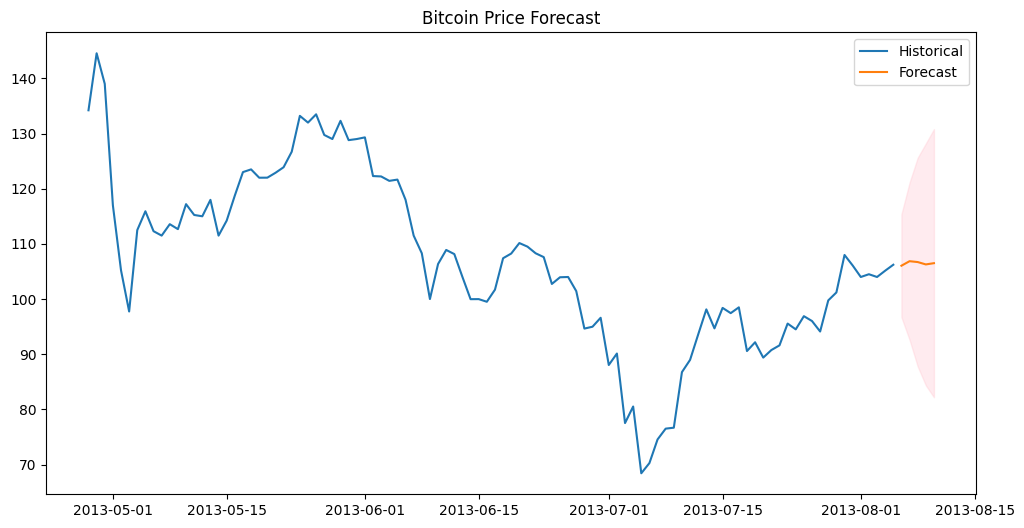

In [ ]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
import pandas as pd

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")

# Fit the ARIMA model with the identified best parameters
best_model = ARIMA(btc_close, order=(2, 1, 2))
fitted_model = best_model.fit()

# Summary of the model
model_summary = fitted_model.summary()
print(model_summary)

# Perform a forecast
forecast = fitted_model.get_forecast(steps=5)
forecast_index = pd.date_range(start=btc_close.index[-1] + pd.Timedelta(days=1), periods=5, freq='D')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plot the forecast alongside the historical data
plt.figure(figsize=(12, 6))
plt.plot(btc_close, label='Historical')
plt.plot(forecast_series, label='Forecast')
plt.fill_between(forecast_index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('Bitcoin Price Forecast')
plt.legend()
plt.show()


The plot should show the historical close prices of Bitcoin along with the forecasted values and a confidence interval. This visual representation will give you an idea of how the model expects the price to move in the short term.

##Insights

This solution notebook has walked through the process of loading cryptocurrency data, performing exploratory data analysis, and building an ARIMA model for Bitcoin price forecasting. This involved has several key steps.

Beginning with data preparation, we ensure that the historical prices are correctly formatted and indexed by date. This allows us to treat the data as a time series, an essential requirement for time-dependent analysis. By filtering the dataset to focus solely on Bitcoin and its closing prices, we target the most relevant information for our forecasting model. Interpolating any missing values further ensures the dataset's integrity, allowing the ARIMA model to function correctly without interruptions or inaccuracies.

Building the ARIMA model requires selecting appropriate parameters, denoted as (p, d, q). These parameters define the autoregressive order, the degree of differencing needed to make the data stationary, and the moving average order, respectively. The model fitting process involves trying various combinations of these parameters and selecting the one with the lowest Akaike Information Criterion (AIC). The AIC helps balance model fit and complexity, ensuring that we do not overfit the model to the historical data. In our case, the ARIMA(2, 1, 2) model was identified as the best fit, indicating it uses two lag observations, one differencing step, and a moving average of two lagged forecast errors.

Once the model is fitted, we generate forecasts for the next five days and visualize the results alongside the historical data. This visualization provides a clear picture of the expected future trends and includes confidence intervals to indicate the range within which we expect the true values to fall. This approach not only offers a data-driven prediction but also conveys the inherent uncertainties in the forecast, allowing for more informed and strategic decision-making. By understanding and applying these steps, we harness the power of statistical modeling to predict future trends in volatile markets like cryptocurrencies, enabling businesses to make better-informed decisions based on robust, data-driven insights.













##Credits
This mini case study was developed by Darshan Desai, edited by Ben Taylor, and leveraged insights generated by ChatGPT.

